# ABS Monthly Consumer Price Index Indicator 6484

## Python set-up

In [1]:
# analytic imports
import matplotlib.pyplot as plt
import pandas as pd

# local imports
from abs_data_capture import (
    AbsLandingPage,
    find_id,
    get_abs_data,
    get_fs_constants,
    get_plot_constants,
    metacol,
)
from henderson import hma
from plotting import (
    COLOR_RED,
    calc_growth,
    clear_chart_dir,
    finalise_plot,
    line_plot,
    plot_growth,
    set_chart_dir,
)
from utility import annualise_rates

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = True

## Get data from ABS

In [2]:
def get_data() -> tuple[dict[str, pd.DataFrame], pd.DataFrame, str, pd.Timestamp]:
    """Get ABS data, create plot directories."""

    # get data
    landing_page = AbsLandingPage(
        theme="economy",
        parent_topic="price-indexes-and-inflation",
        topic="monthly-consumer-price-index-indicator",
    )
    abs_dict_ = get_abs_data(landing_page, verbose=False)  # tricky
    source_, chart_dir, _, meta_ = get_fs_constants(abs_dict_, landing_page)
    recent_, _plot_times, _plot_tags = get_plot_constants(meta_)

    # create plot plot directories
    set_chart_dir(chart_dir)
    clear_chart_dir(chart_dir)

    return abs_dict_, meta_, source_, recent_

In [3]:
abs_dict, meta, source, recent = get_data()

## Plot

### Set-up 

In [4]:
plt.style.use("fivethirtyeight")
TARGET = {
    "ymin": 2,
    "ymax": 3,
    "color": "#dddddd",
    "label": "2-3% annual inflation target",
    "zorder": -1,
}

### Plot growth - combined line/bar charts

In [5]:
def cpi_growth():
    """Produce CPI growth charts."""

    rows = meta[meta[metacol.did].str.contains("Index Numbers")]

    for index, row in rows.iterrows():
        # get data for the plot
        did, table = row[metacol.did], row[metacol.table]
        series_type, series_id = row[metacol.stype], row[metacol.id]
        name = did.split(";")[1].strip()
        index = abs_dict[table][series_id]
        growth = calc_growth(index)

        # plot the data
        ax = plot_growth(*growth, from_=recent)
        if ax:
            long_name = 40
            separator = " " if len(name) < long_name else "\n"
            finalise_plot(
                ax,
                title=f"Price Growth:{separator}{name}",
                ylabel="Per cent",
                rfooter=source,
                axhspan=TARGET,
                legend={"loc": "best", "fontsize": "x-small"},
                lfooter=f"Australia: {series_type.capitalize()} series. ",
                y0=True,
                show=SHOW,
            )

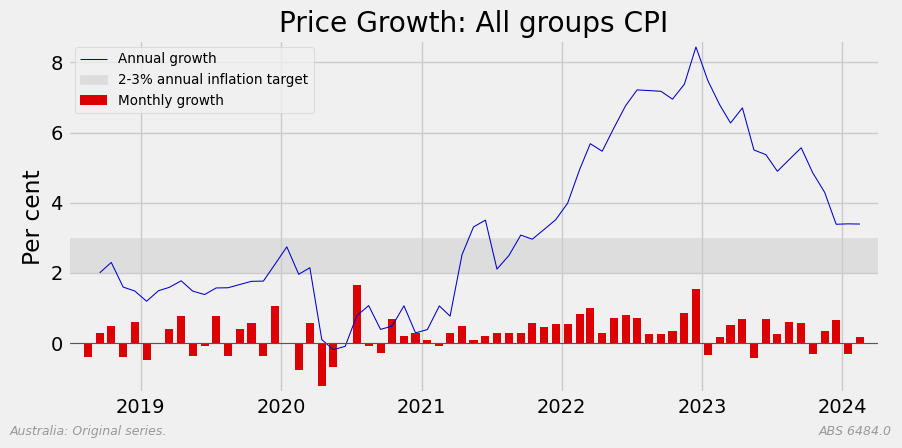

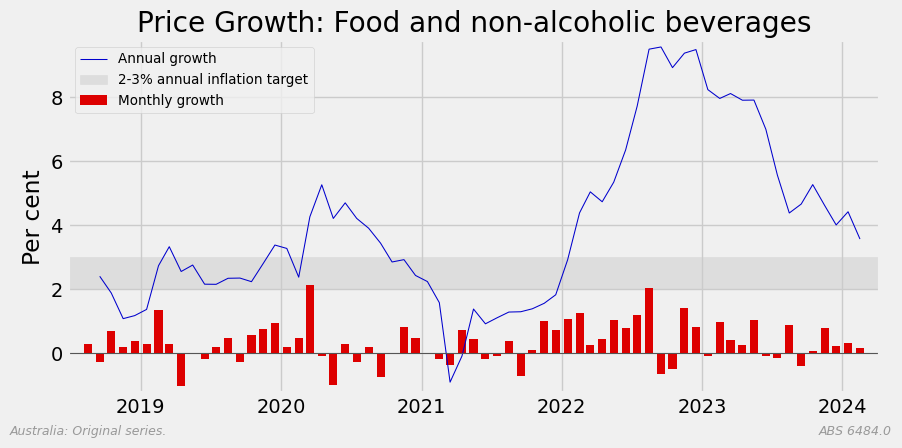

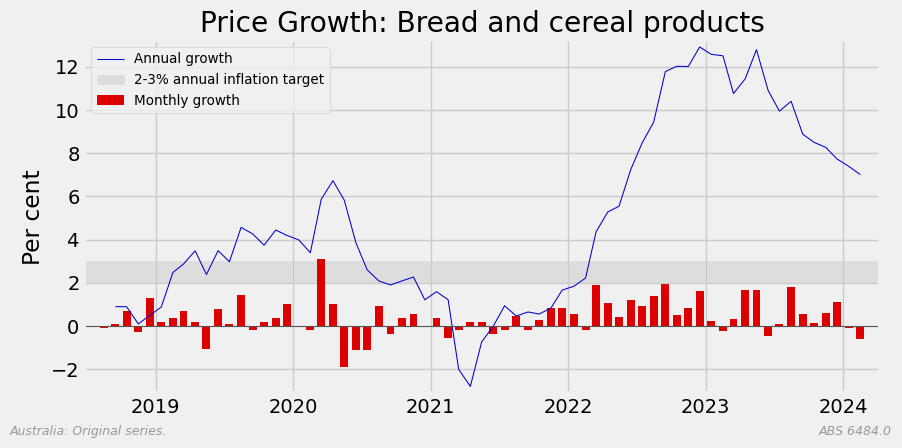

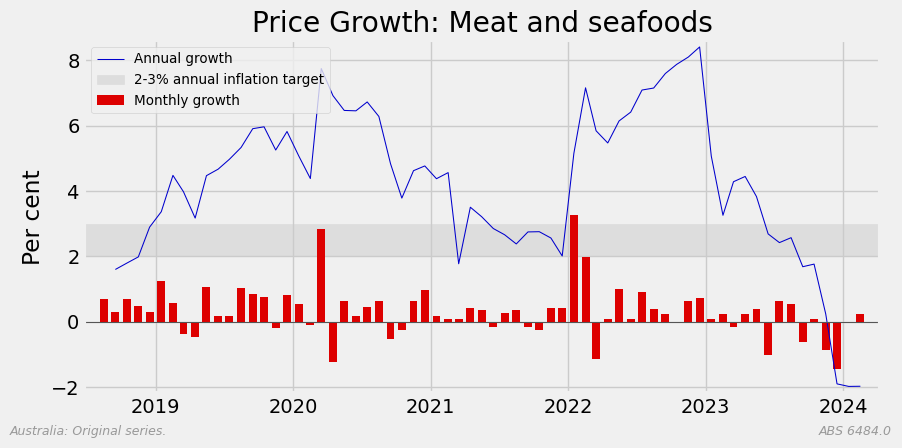

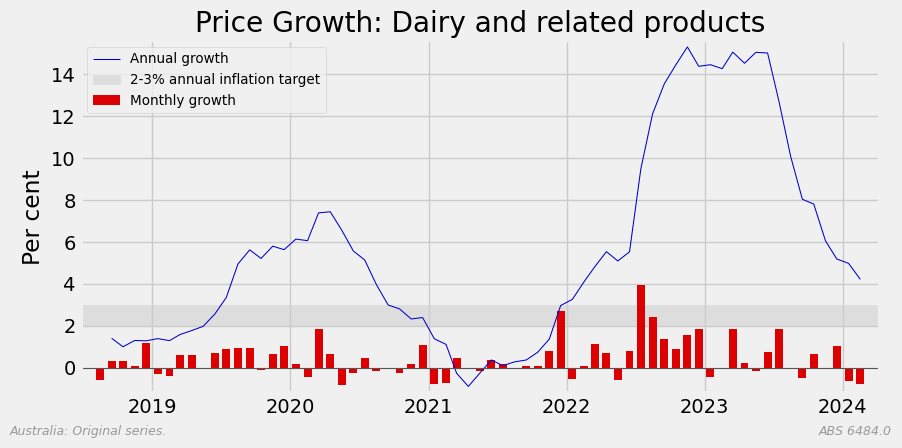

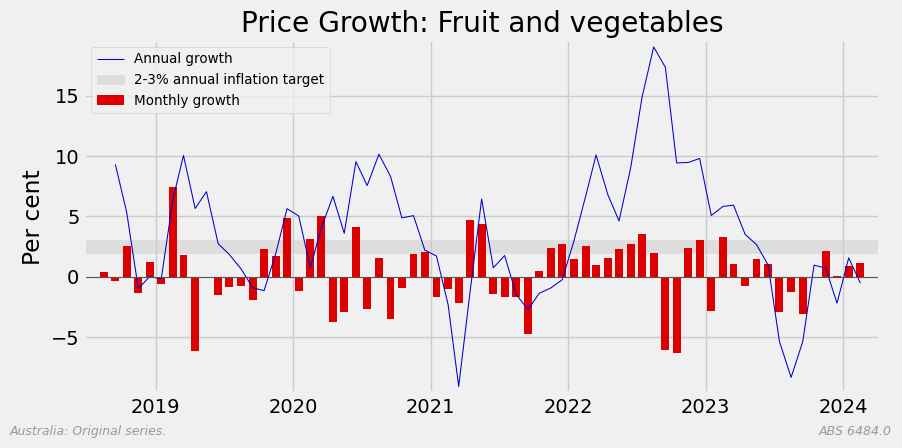

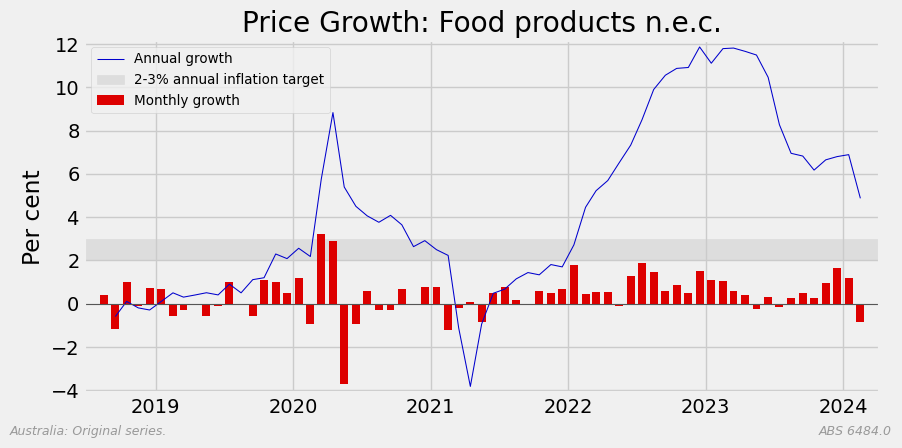

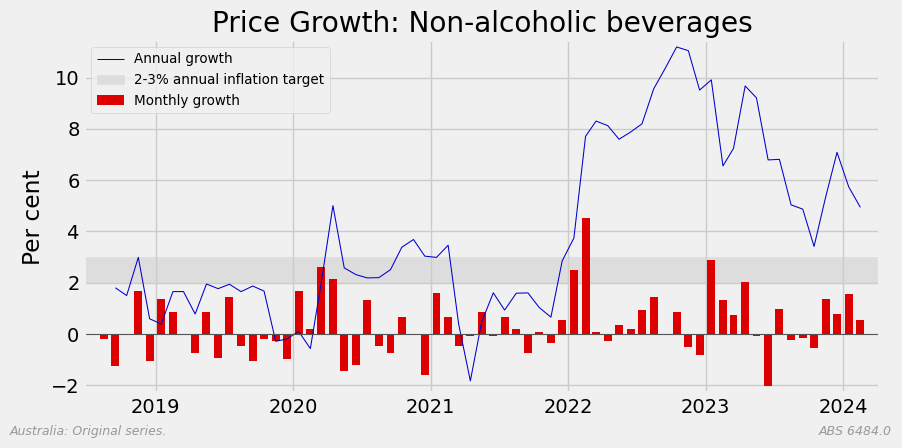

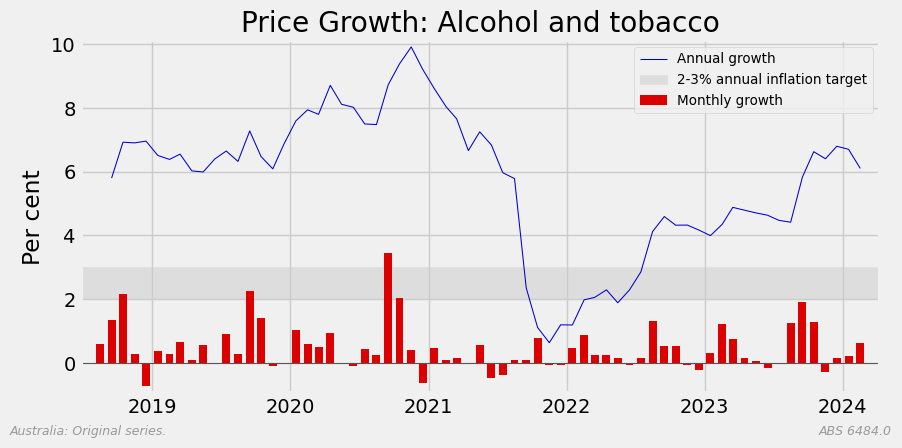

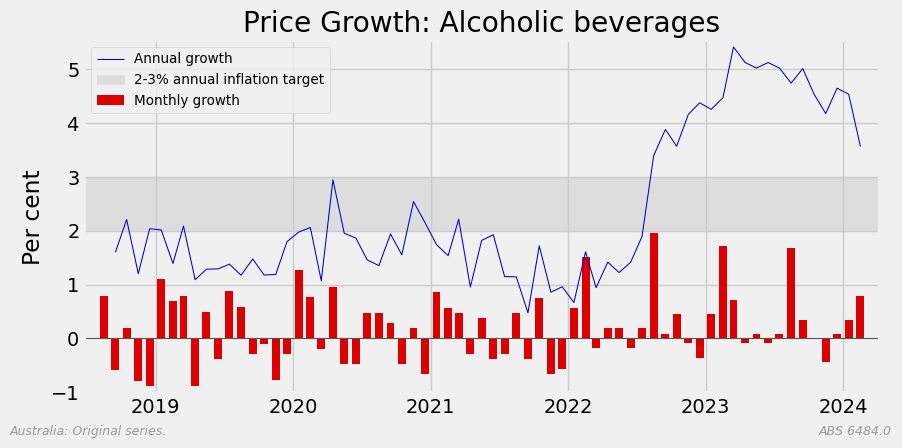

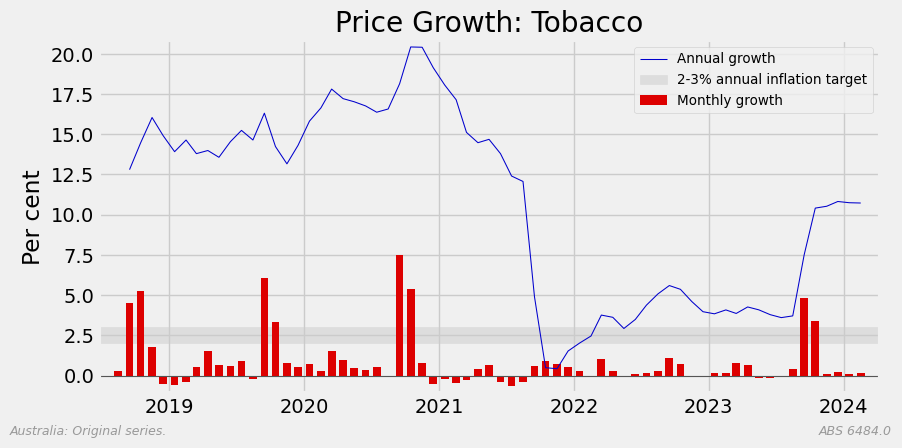

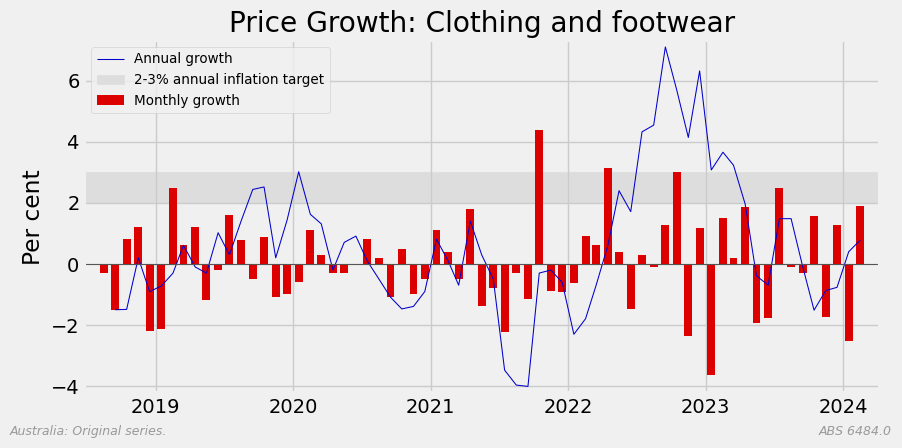

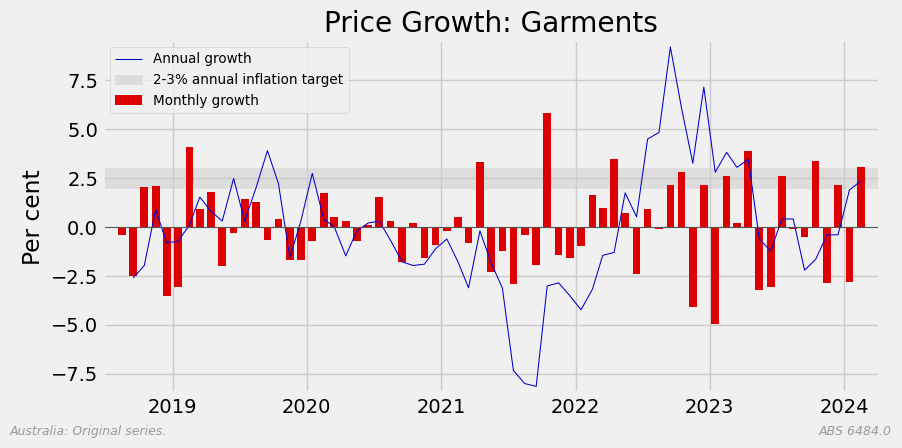

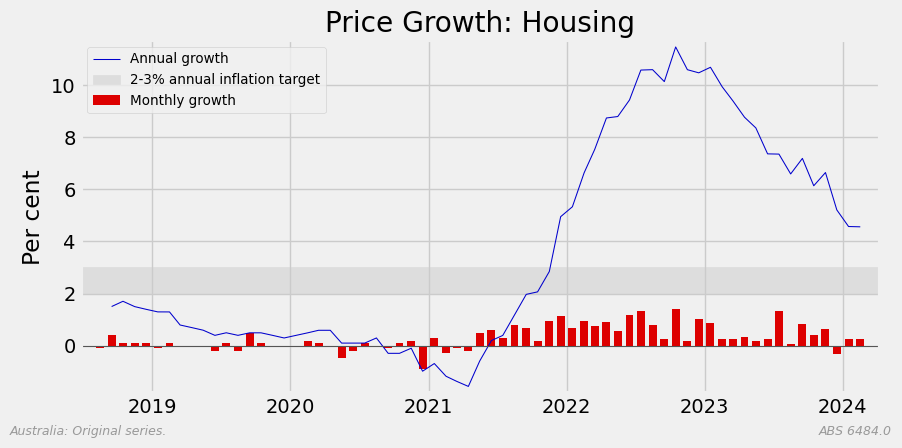

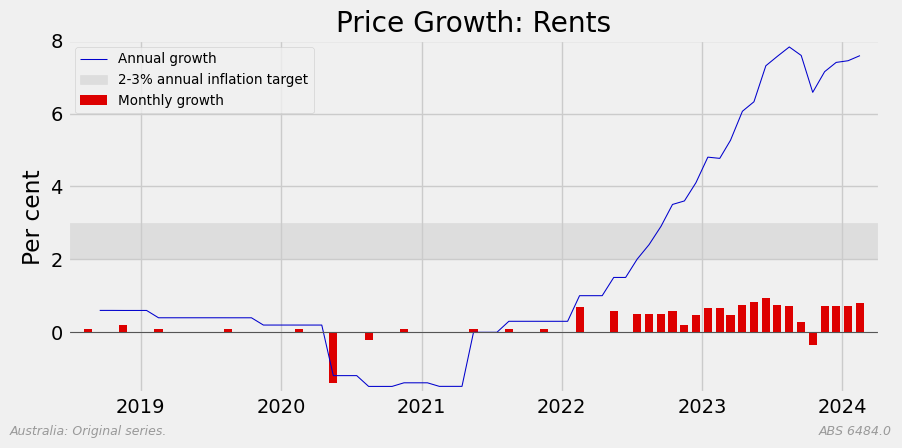

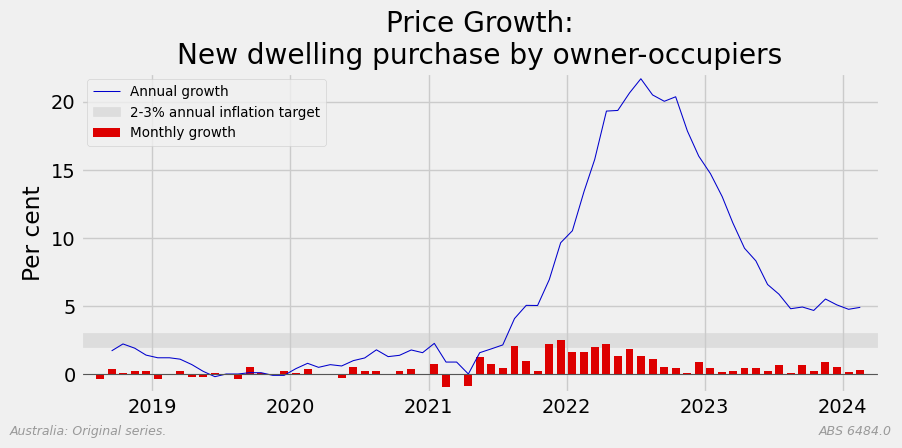

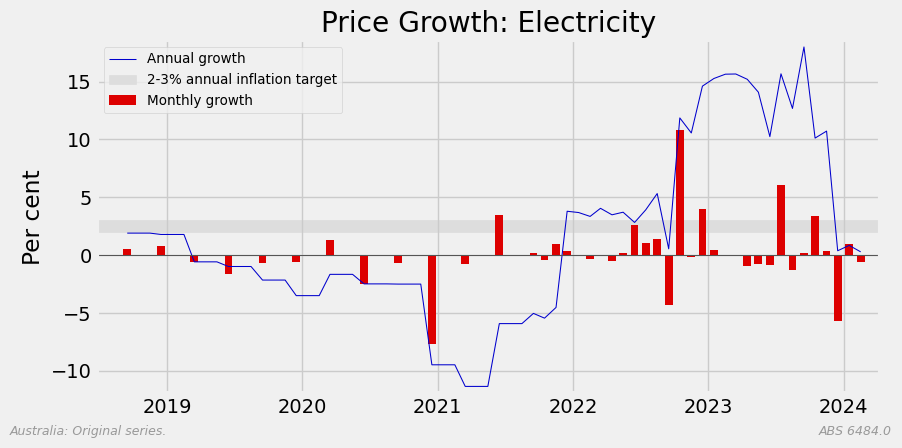

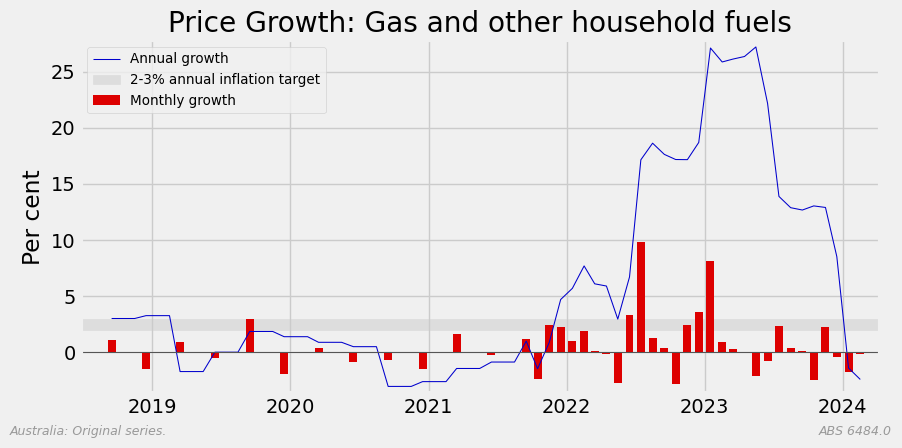

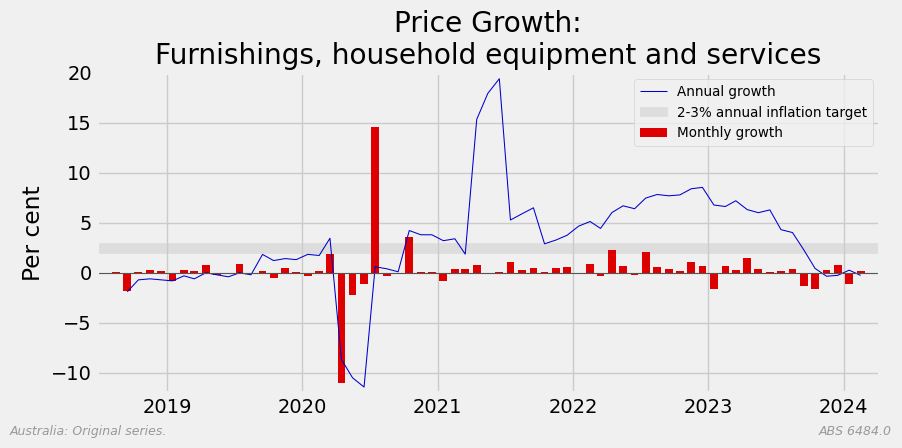

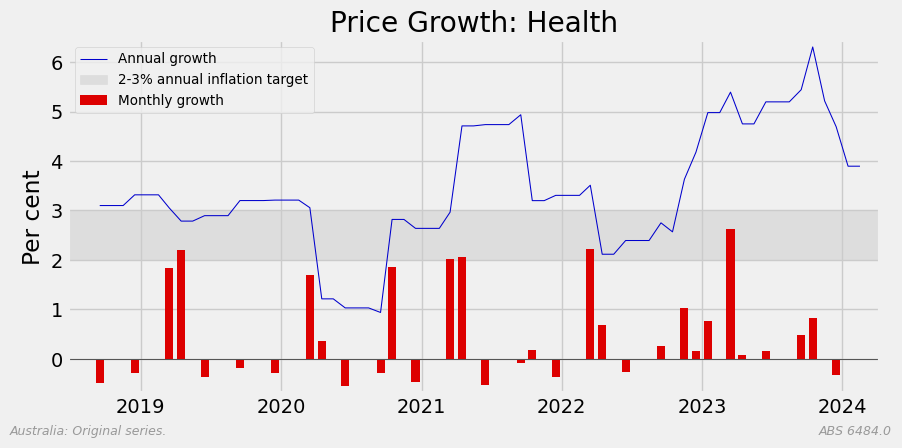

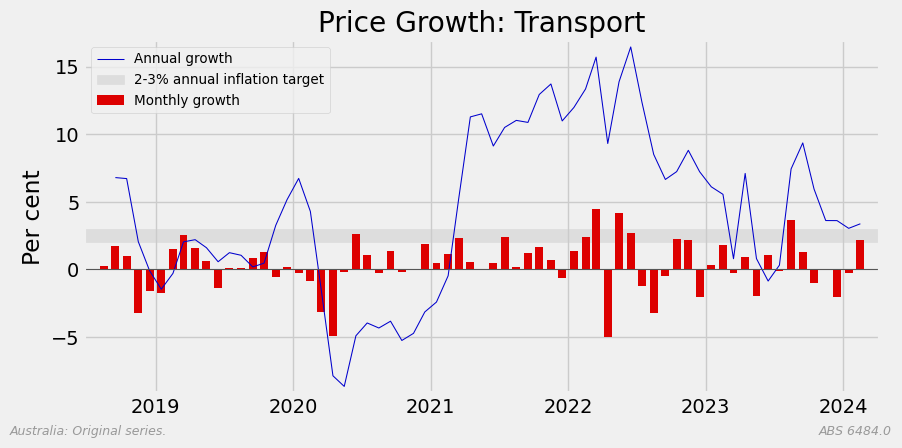

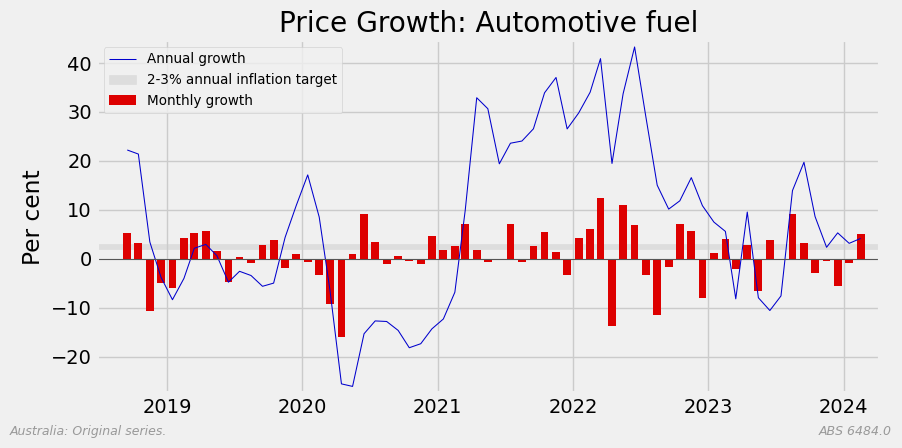

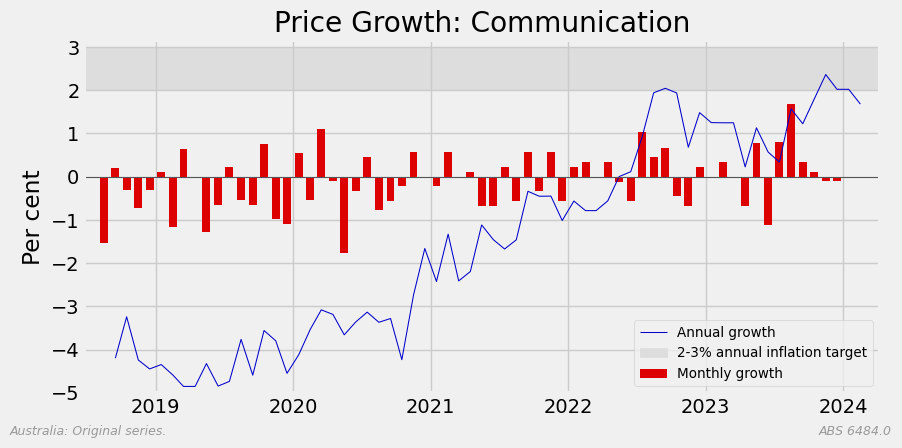

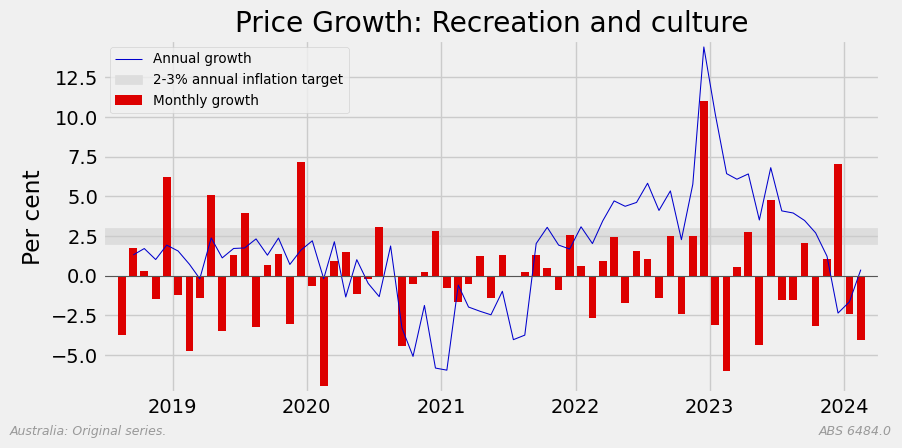

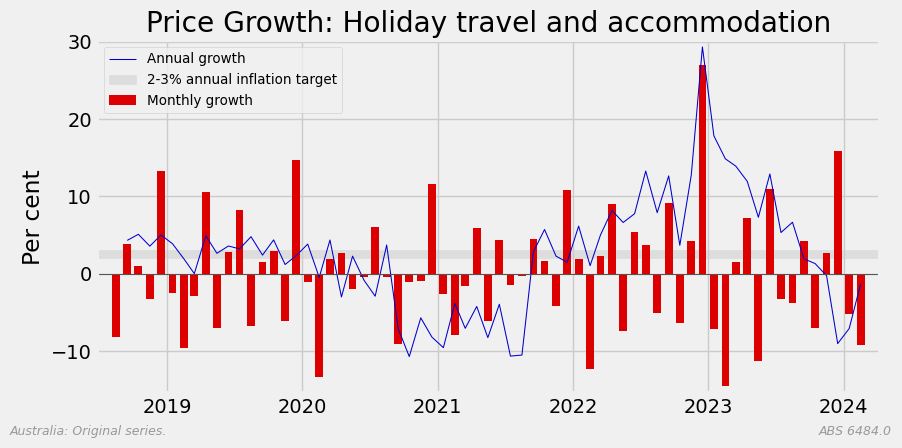

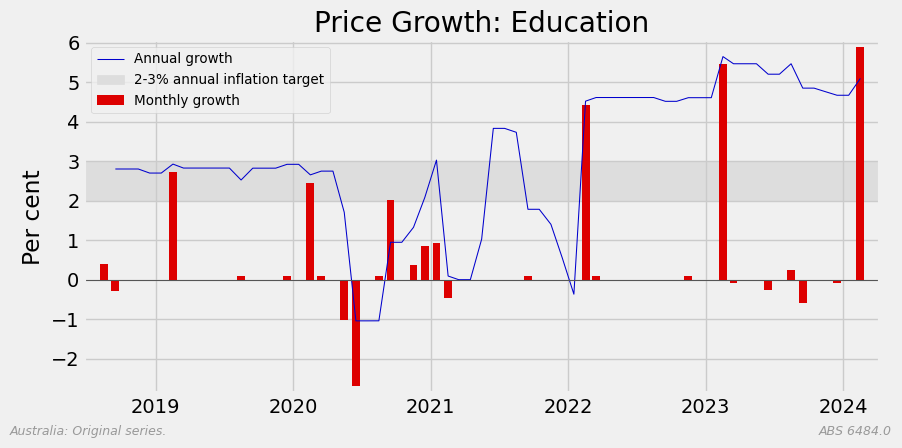

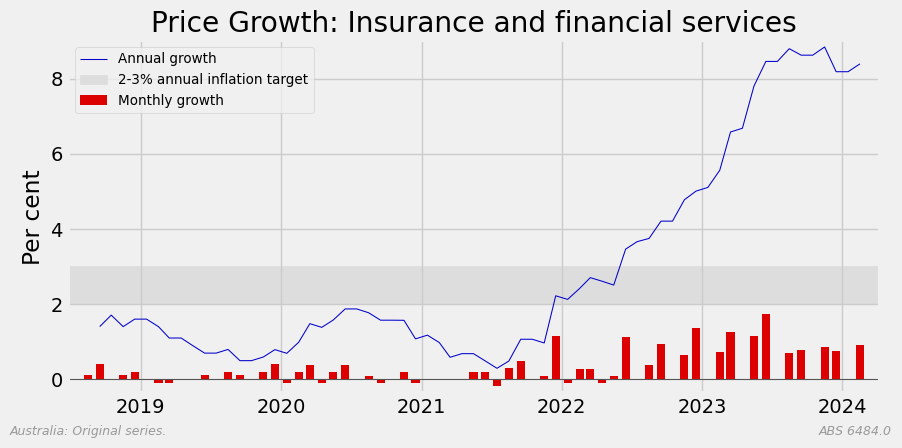

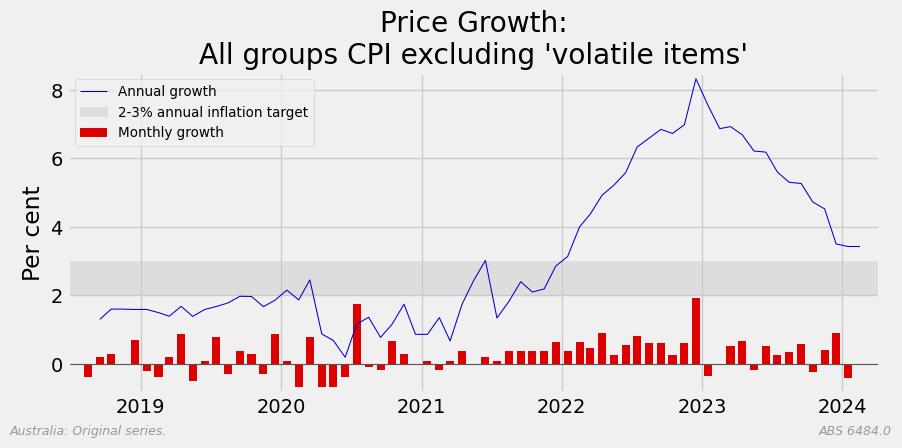

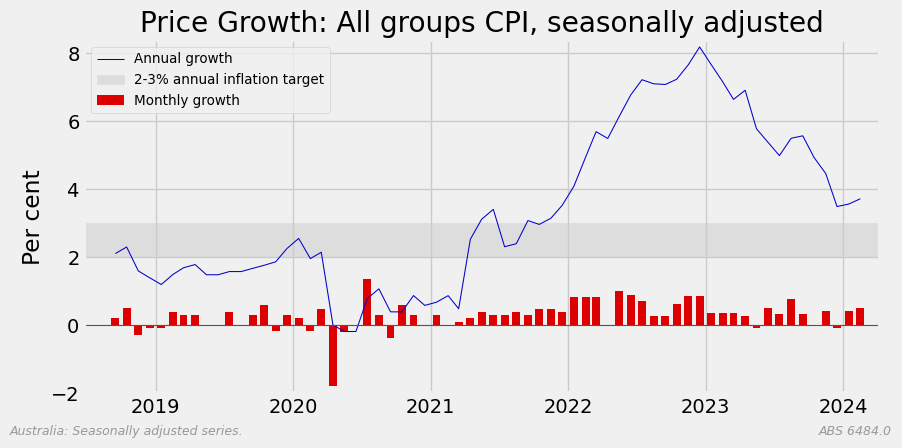

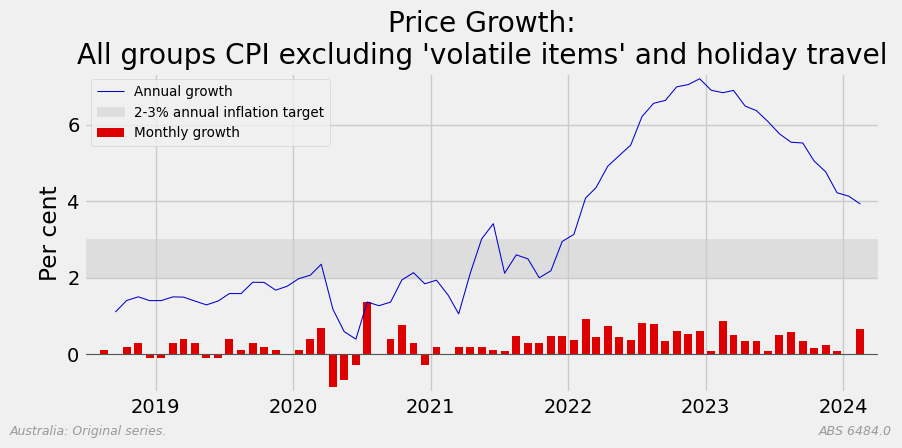

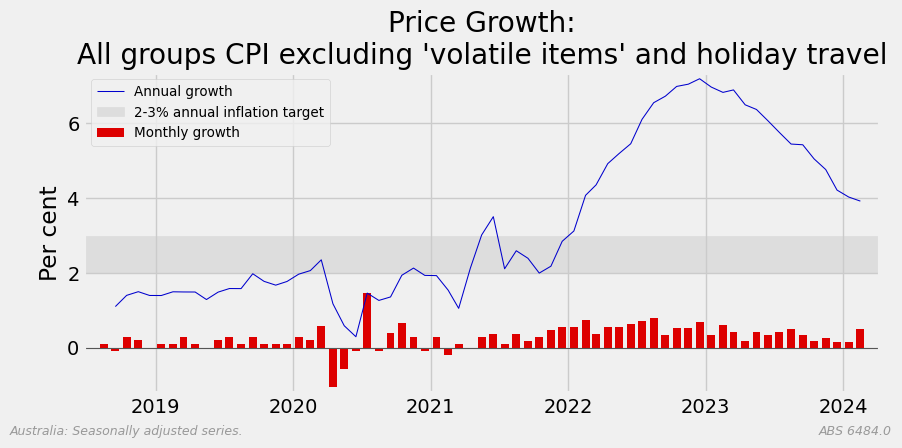

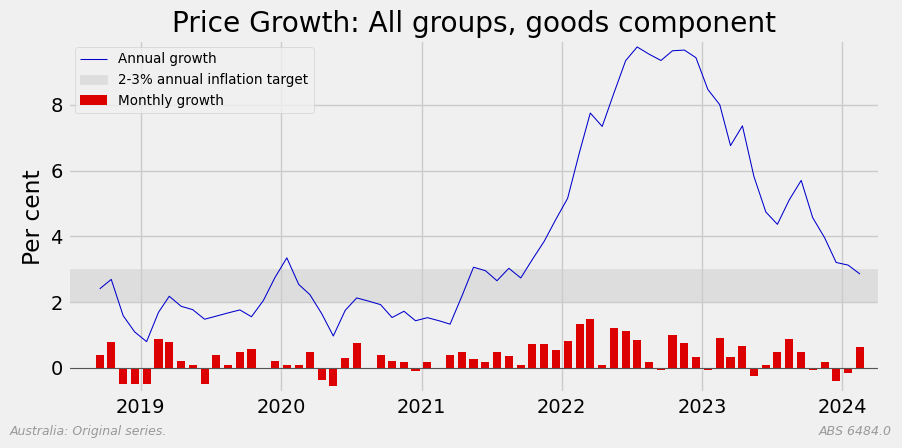

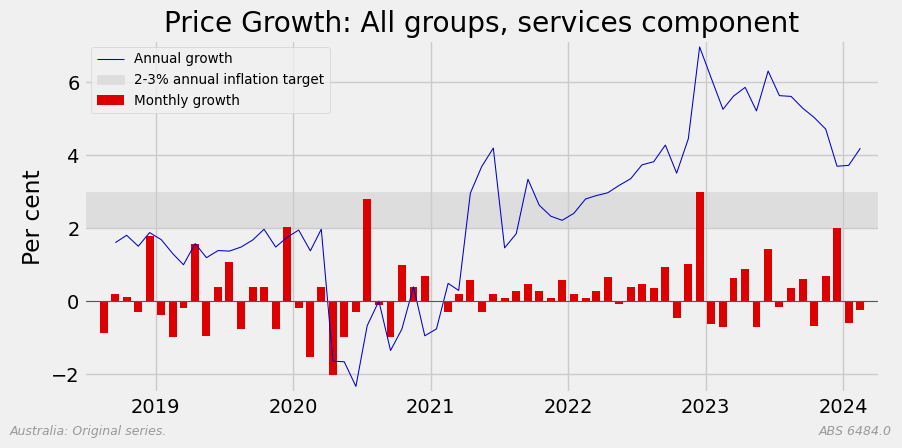

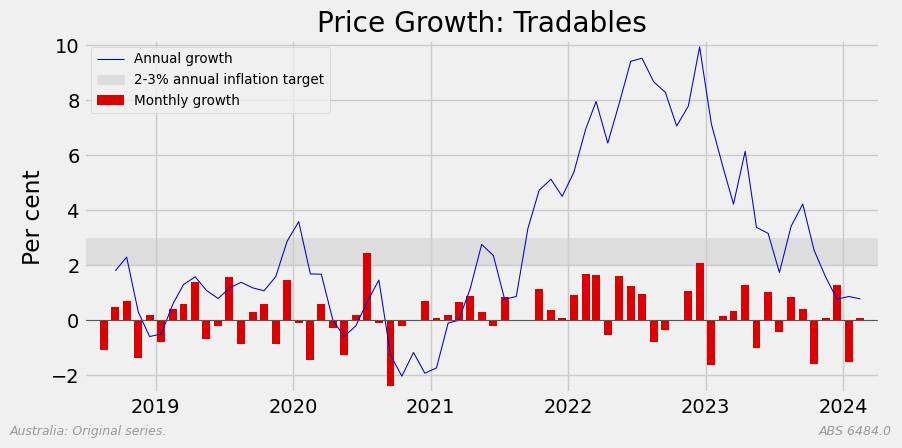

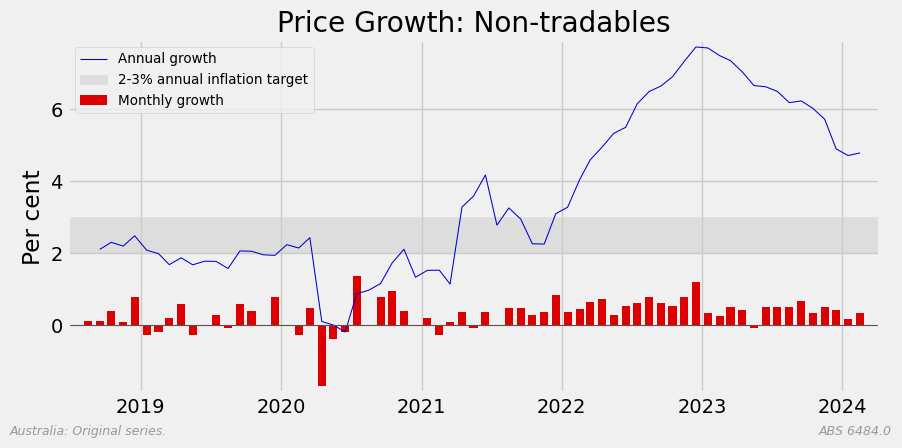

In [6]:
cpi_growth()

### Annualised growth

In [7]:
def line_and_target_plot(series: pd.Series, **kwargs) -> None:
    """Finish up plot."""

    ax = series.plot(lw=2, color=COLOR_RED)
    finalise_plot(
        ax,
        axhspan=TARGET,
        y0=True,
        rfooter=source,
        ylabel="Per cent",
        show=SHOW,
        legend={"loc": "best", "fontsize": "x-small"},
        **kwargs,
    )


def annualised_growth() -> None:
    """Produce annualised growth charts."""

    henderson = 13

    for series_name in (
        "Index Numbers ;  All groups CPI ;  Australia ;",
        "Index Numbers ;  All groups CPI, seasonally adjusted ;  Australia ;",
    ):
        print(series_name)
        table = "1"
        selector = {series_name: metacol.did}
        series_id, _ = find_id(meta, selector, verbose=False)
        series_type = (
            "Seasonally Adjusted"
            if "seasonally adjusted" in series_name
            else "Original"
        )
        series_name = series_name.split(";")[1].strip()
        long_name = 20
        separator = " " if len(series_name) < long_name else "\n"
        name = f"{separator}{series_name}"
        lfooter = f"Australia. {series_type.capitalize()} series. "

        quarterly = annualise_rates(
            abs_dict[table][series_id].pct_change(3), 4
        ).dropna()
        quarterly.name = series_name
        line_and_target_plot(
            quarterly,
            title=f"Quarterly Price Growth Annualised:{name}",
            lfooter=f"{lfooter} Endpoint: {quarterly.iloc[-1]:0.2f}%",
        )

        quarterly_s = hma(quarterly, henderson)
        quarterly_s.name = series_name
        line_and_target_plot(
            quarterly_s,
            title=f"Quarterly Price Growth Annualised/Smoothed:{name}",
            lfooter=f"{lfooter}{henderson}-term Henderson moving average. "
            f"Endpoint: {quarterly_s.iloc[-1]:0.2f}%",
        )

        monthly = annualise_rates(abs_dict[table][series_id].pct_change(1), 12).dropna()
        monthly.name = series_name
        line_and_target_plot(
            monthly,
            title=f"Monthly Price Growth Annualised:{name}",
            lfooter=f"{lfooter} Endpoint: {monthly.iloc[-1]:0.2f}%",
        )

        monthly_s = hma(monthly, henderson)
        monthly_s.name = series_name
        line_and_target_plot(
            monthly_s,
            title=f"Monthly Price Growth Annualised/Smoothed:{name}",
            lfooter=f"{lfooter}{henderson}-term Henderson moving average. "
            f"Endpoint: {monthly_s.iloc[-1]:0.2f}%",
        )

Index Numbers ;  All groups CPI ;  Australia ;


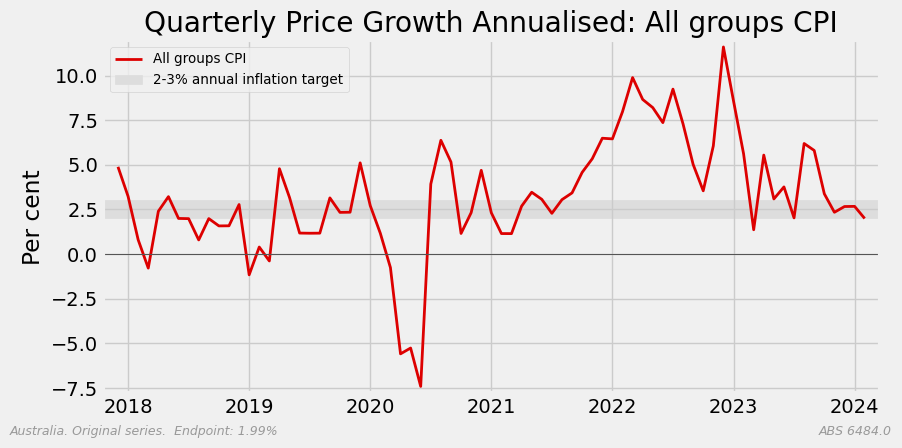

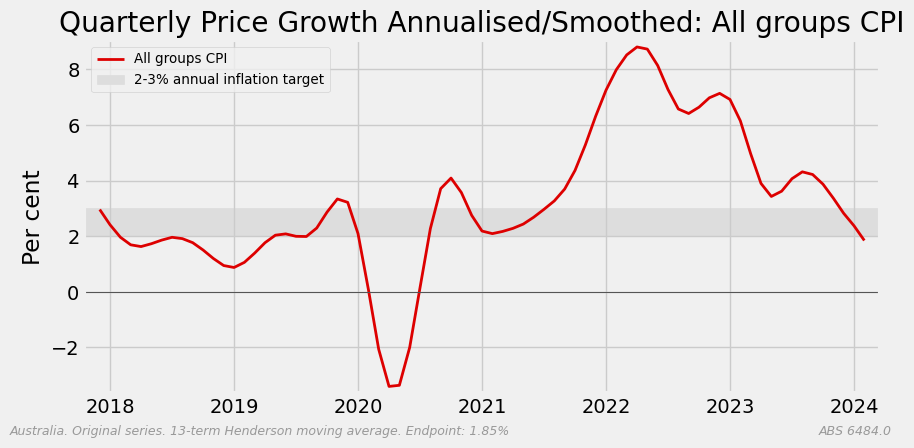

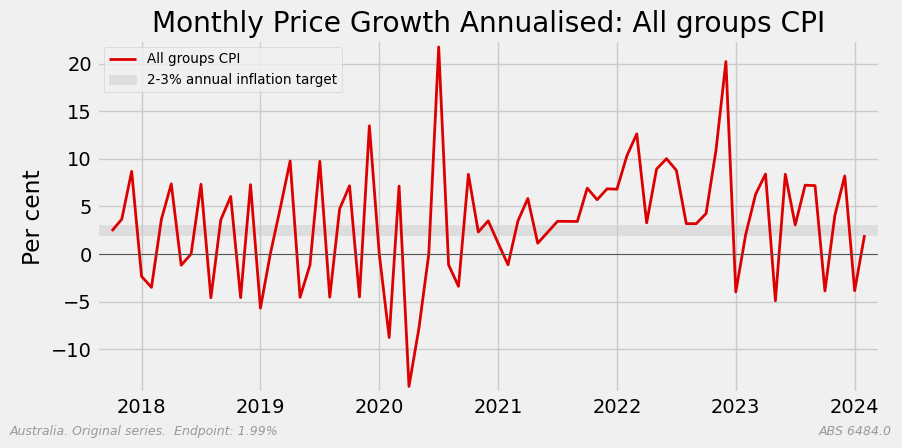

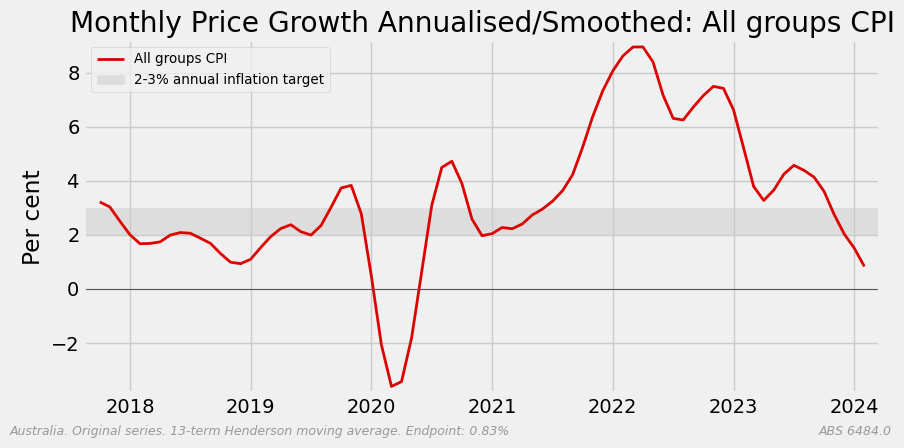

Index Numbers ;  All groups CPI, seasonally adjusted ;  Australia ;


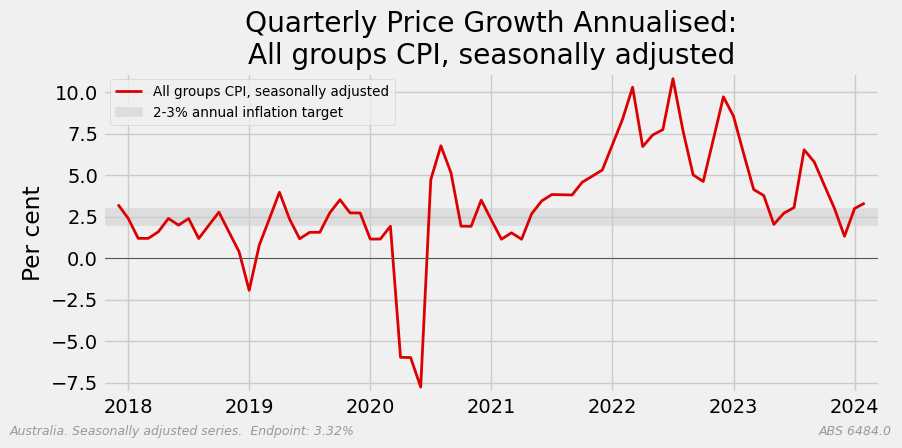

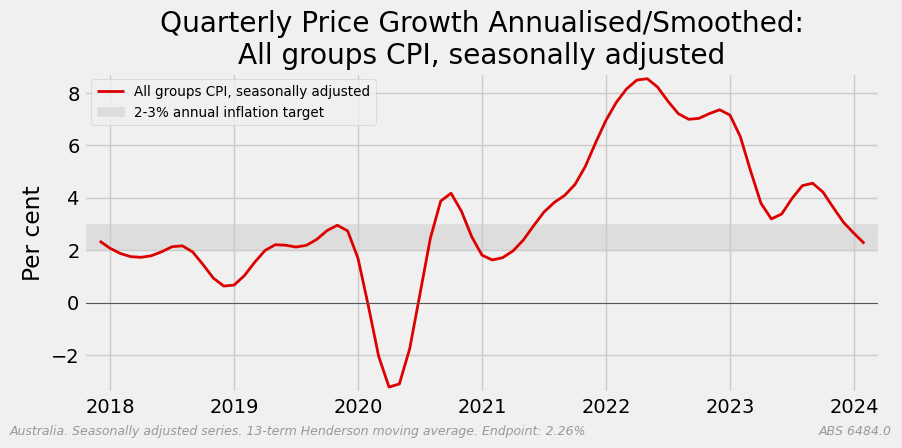

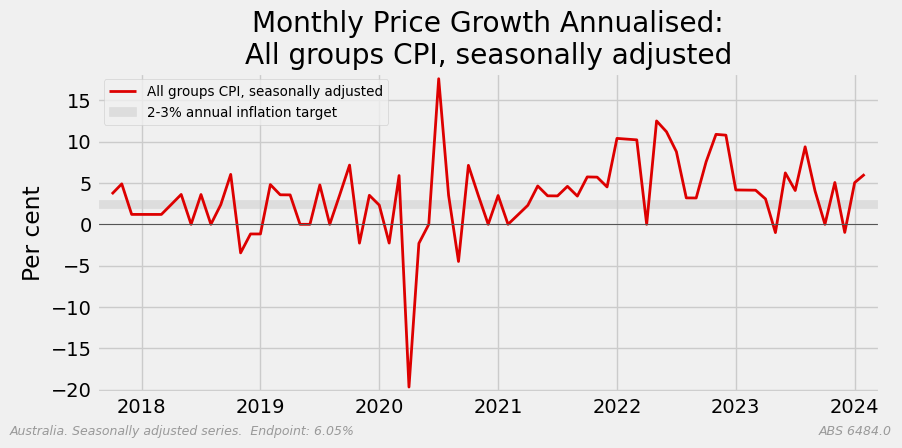

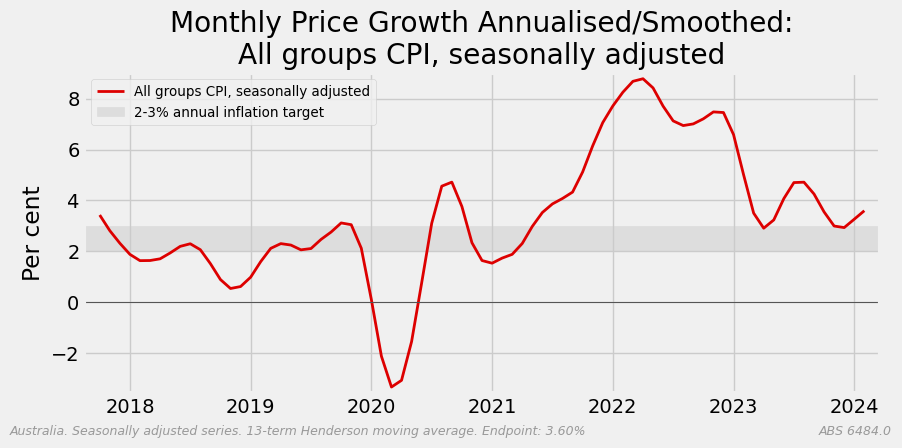

In [8]:
annualised_growth()

### Selected sub items

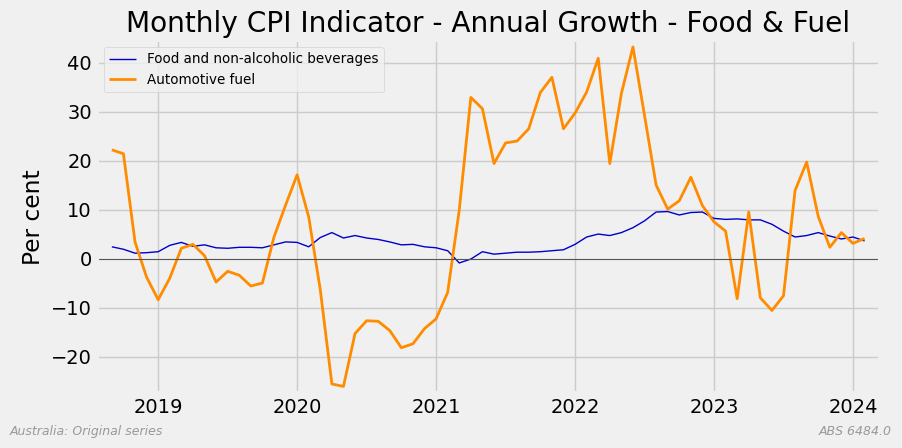

In [9]:
def food_fuel() -> None:
    """Produce food and fuel sub-item charts."""

    annual = "Corresponding Month of Previous Year"
    selectors = {
        "Food and non-alcoholic beverages": {
            "Food and non-alcoholic beverages": metacol.did,
            "Original": metacol.stype,
            annual: metacol.did,
        },
        "Automotive fuel": {
            "Automotive fuel": metacol.did,
            "Original": metacol.stype,
            annual: metacol.did,
        },
    }

    data = pd.DataFrame()
    for name, selector in selectors.items():
        series_id, _ = find_id(meta, selector, verbose=False)
        table = meta.loc[meta["Series ID"] == series_id, "Table"].values[0]
        data[name] = abs_dict[table][series_id]

    title = "Monthly CPI Indicator - Annual Growth - Food & Fuel"
    tag = "1"
    series_type = "Original series"
    line_plot(
        data,
        title=title,
        ylabel="Per cent",
        width=(1, 2),
        tags=tag,
        legend={"loc": "best", "fontsize": "x-small"},
        rfooter=f"{source}",
        lfooter=f"Australia: {series_type}",
        y0=True,
        show=SHOW,
    )


food_fuel()

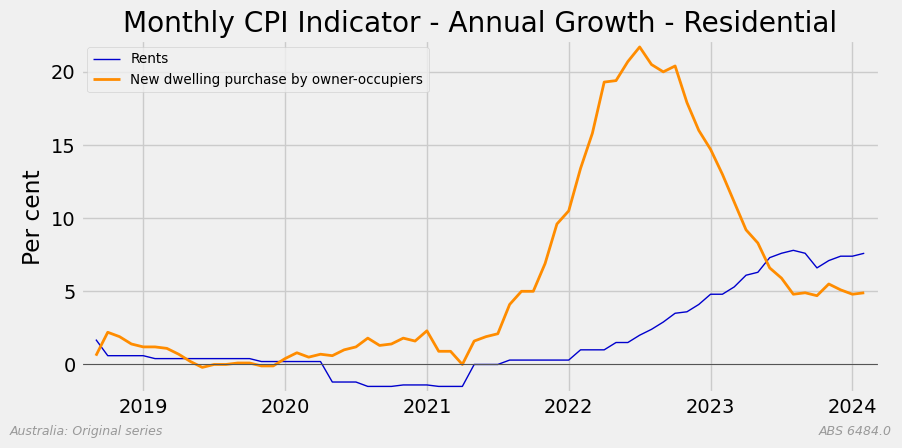

In [10]:
def housing() -> None:
    """Produce housing related charts."""

    annual = "Corresponding Month of Previous Year"
    selectors = {
        "Rents": {
            "Rents": metacol.did,
            "Original": metacol.stype,
            annual: metacol.did,
        },
        "New dwelling purchase by owner-occupiers": {
            "New dwelling purchase by owner-occupiers": metacol.did,
            "Original": metacol.stype,
            annual: metacol.did,
        },
    }

    data = pd.DataFrame()
    for name, selector in selectors.items():
        series_id, _ = find_id(meta, selector, verbose=False)
        table = meta.loc[meta[metacol.id] == series_id, "Table"].values[0]
        data[name] = abs_dict[table][series_id]

    title = "Monthly CPI Indicator - Annual Growth - Residential"
    tag = "2"
    series_type = "Original series"
    line_plot(
        data,
        title=title,
        ylabel="Per cent",
        width=(1, 2),
        tags=tag,
        legend={"loc": "best", "fontsize": "x-small"},
        rfooter=f"{source}",
        lfooter=f"Australia: {series_type}",
        y0=True,
        show=SHOW,
    )


housing()

### Annualised SA v Orig

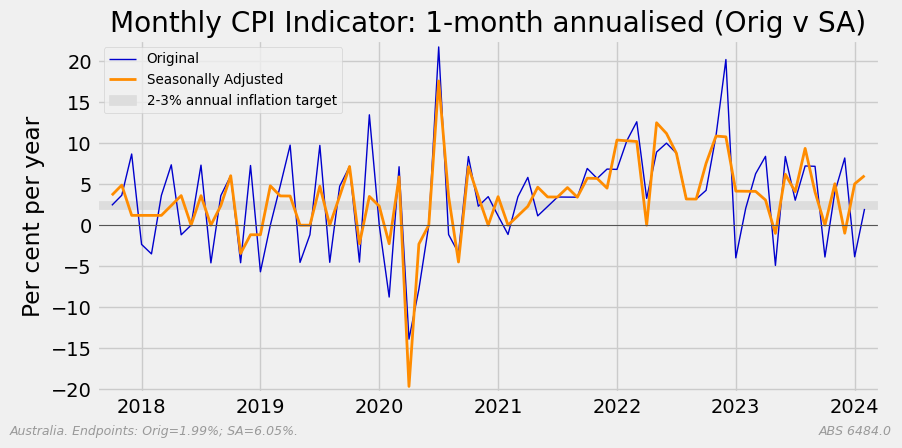

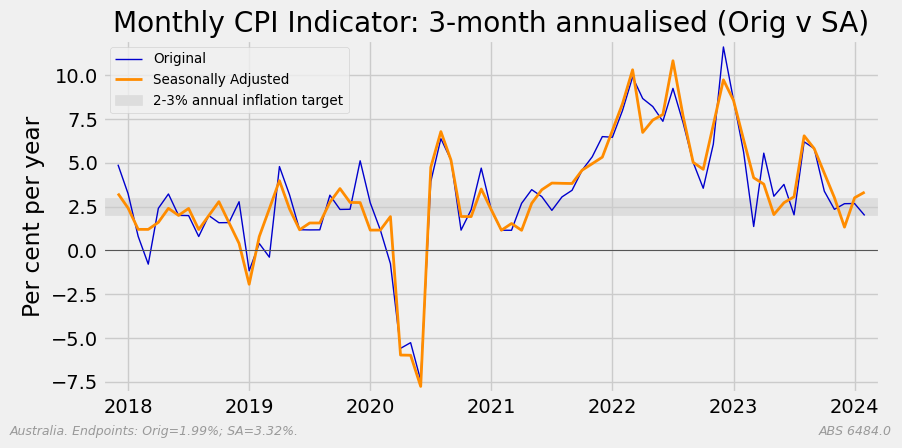

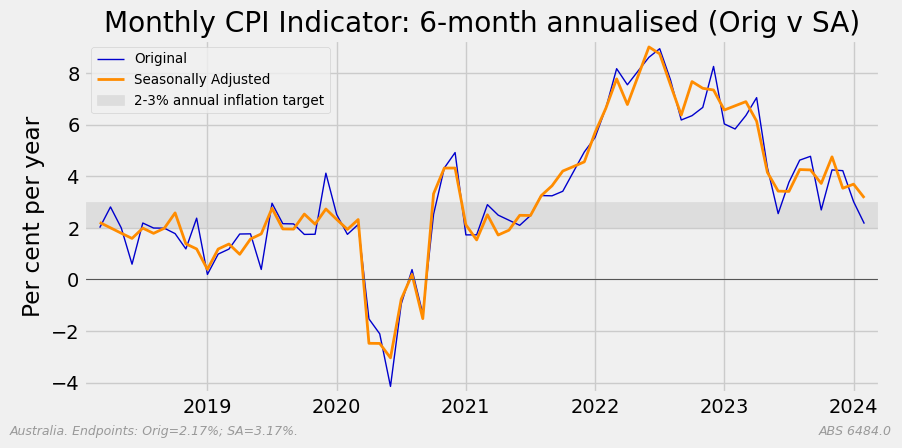

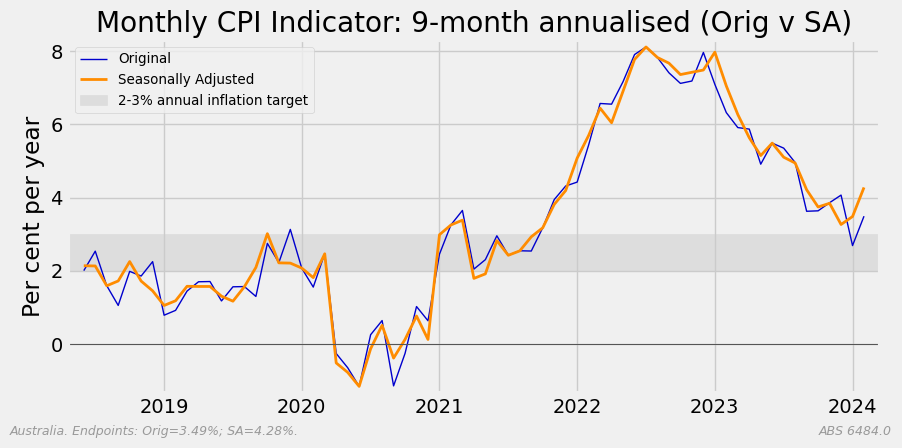

In [11]:
def sa_orig_comparative():
    """Plot the Monthly CPI Indicator,
    for various periods annualised, SA v Orig."""

    to_get = {
        "Original": "Index Numbers ;  All groups CPI ;  Australia ;",
        "Seasonally Adjusted": 
            "Index Numbers ;  All groups CPI, seasonally adjusted ;  Australia ;",
    }
    index = {}
    table = "1"
    data = abs_dict[table]
    for stype, did in to_get.items():
        search = {table: metacol.table, stype: metacol.stype, did: metacol.did}
        series_id, _ = find_id(meta, search, exact=True, verbose=False)
        index[stype] = data[series_id]

    for p in (1, 3, 6, 9):
        annualised = {}
        for stype, data in index.items():
            annualised[stype] = annualise_rates(
                data.pct_change(p), 12 / p
            ).dropna()
        plot_data = pd.DataFrame(annualised).dropna()
        line_plot(
            plot_data,
            title=f"Monthly CPI Indicator: {p}-month annualised (Orig v SA)",
            ylabel="Per cent per year",
            width=(1, 2),
            rfooter=f"{source}",
            lfooter="Australia. Endpoints: "
            f"Orig={plot_data['Original'].iloc[-1]:0.2f}%; "
            f"SA={plot_data['Seasonally Adjusted'].iloc[-1]:0.2f}%. ",
            y0=True,
            axhspan=TARGET,
            show=SHOW,
        )


sa_orig_comparative()

## Finished

In [12]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Mar 29 2024 14:50:18

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pandas    : 2.2.1
matplotlib: 3.8.3

Watermark: 2.4.3



In [13]:
print("Done")

Done
